# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
TRAIN_PATH = '/kaggle/input/titanic/train.csv'
TEST_PATH = '/kaggle/input/titanic/test.csv'
TEST_LABEL = '/kaggle/input/titanic/gender_submission.csv'

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
test_label = pd.read_csv(TEST_LABEL)

# Data Exploration

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(f"Dataset shape (rows, columns): {train_df.shape}")
print("\n")

print("Data types and non-null values:")
train_df.info()

Dataset shape (rows, columns): (891, 12)


Data types and non-null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
print("Summary of Dataset")
train_df.describe()

Summary of Dataset


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
merged_test_df = pd.merge(test_label, test_df, on='PassengerId')

In [8]:
merged_test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Handling Null Values

In [9]:
train_df.isnull().sum() #checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
null_age_rows = train_df[train_df['Age'].isnull()]
null_age_rows .head()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [11]:
train_df.dropna(subset=['Age'], inplace=True)

We are dropping the null values in Age column because the dataset already provides estimated values in the form of xx.5. If we further impute using the average, it may distort the actual predictions, since some values are already approximated.

In [12]:
train_df['Cabin'].fillna(0, inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Filling missing Cabin values with 0, as these passengers may be general customers without a cabin purchase.

In [13]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

Fill the missing Embarked values with the most occuring vlaue since there are only two of them.

In [14]:
train_df.shape

(714, 12)

# EDA

## Survival Breakdown

### Effect of Age & Gender on Survival

invalid value encountered in divide


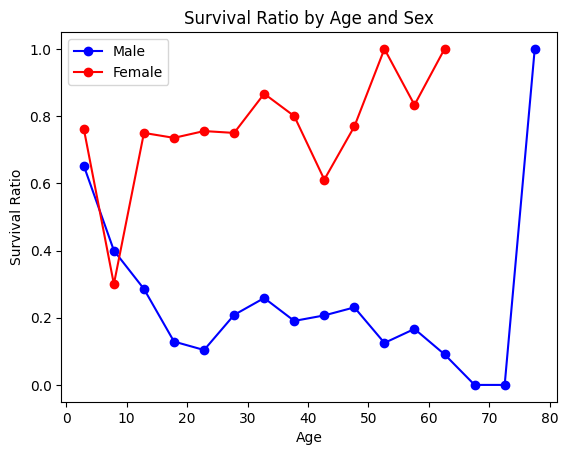

In [15]:
bins = 16
bin_edges = np.linspace(train_df['Age'].min(), train_df['Age'].max(), bins+1)

# Male survival ratio
counts_male, _ = np.histogram(train_df[train_df['Sex'] == 'male']['Age'], bins=bin_edges)
counts_male_survived, _ = np.histogram(train_df[(train_df['Sex'] == 'male') & (train_df['Survived'] == 1)]['Age'], bins=bin_edges)
ratios_male = counts_male_survived / counts_male

# Female survival ratio
counts_female, _ = np.histogram(train_df[train_df['Sex'] == 'female']['Age'], bins=bin_edges)
counts_female_survived, _ = np.histogram(train_df[(train_df['Sex'] == 'female') & (train_df['Survived'] == 1)]['Age'], bins=bin_edges)
ratios_female = counts_female_survived / counts_female

# Mid-points of bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot
plt.plot(bin_centers, ratios_male, label='Male', marker='o', color='blue')
plt.plot(bin_centers, ratios_female, label='Female', marker='o', color='red')

plt.xlabel('Age')
plt.ylabel('Survival Ratio')
plt.title('Survival Ratio by Age and Sex')
plt.legend()
plt.show()

### Effect of Cabin on Survival

In [16]:
unique_cabin_count = train_df['Cabin'].nunique()
print("Number of unique cabins:", unique_cabin_count)

unique_cabins = train_df['Cabin'].unique()
print(unique_cabins)

Number of unique cabins: 135
[0 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'D33' 'B30'
 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110' 'B58 B60'
 'E101' 'D47' 'B86' 'F2' 'C2' 'B19' 'A7' 'C49' 'F4' 'B4' 'B80' 'A31' 'D36'
 'D15' 'C93' 'C78' 'D35' 'C87' 'B77' 'E67' 'B94' 'C125' 'C99' 'C118' 'D7'
 'B49' 'D' 'C22 C26' 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32'
 'B18' 'C124' 'C91' 'E40' 'T' 'E33' 'D37' 'B35' 'E50' 'C82' 'B96 B98'
 'E10' 'C52' 'E44' 'A34' 'C104' 'C111' 'C92' 'E38' 'E12' 'E63' 'B37' 'C30'
 'D20' 'B79' 'E25' 'D46' 'B73' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101'
 'C68' 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48'
 'E58' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C126' 'C45' 'E8' 'B101' 'C46' 'D30' 'E121' 'D11' 'E77' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B69' 'E49' 'D28' 'E17' 'A24' 'C50' 'B42' 'C148']


In [17]:
train_df['Cabin_Letter'] = train_df['Cabin'].str[0]
train_df['Cabin_Letter'] = train_df['Cabin_Letter'].fillna('0')

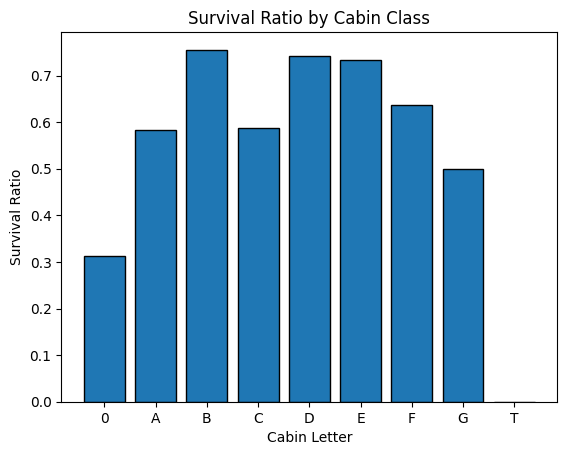

In [18]:
counts_all = train_df.groupby('Cabin_Letter').size()

counts_survived = train_df[train_df['Survived'] == 1].groupby('Cabin_Letter').size()
ratios = (counts_survived / counts_all).fillna(0)

plt.bar(ratios.index, ratios.values, edgecolor='black')
plt.xlabel('Cabin Letter')
plt.ylabel('Survival Ratio')
plt.title('Survival Ratio by Cabin Class')
plt.show()

### Survival Rate by Pclass

The figure layout has changed to tight


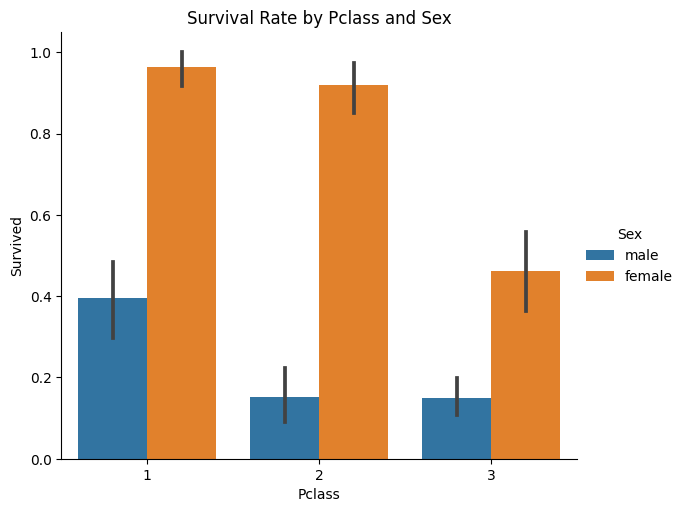

In [19]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_df, kind="bar", height=5, aspect=1.2)

plt.title("Survival Rate by Pclass and Sex")
plt.show()

### Effect of Family Size

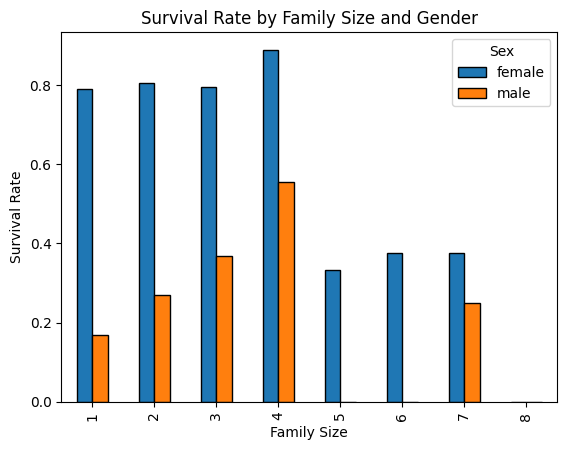

In [20]:
# Add FamilySize column
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Group by FamilySize and Sex
survival_by_family_gender = train_df.groupby(['FamilySize', 'Sex'])['Survived'].mean().unstack()

# Plot
survival_by_family_gender.plot(kind='bar', edgecolor='black')

plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Family Size and Gender')
plt.legend(title='Sex')
plt.show()

In [21]:
# Add FamilySize column
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Count passengers by FamilySize and Pclass
family_pclass_counts = train_df.groupby(['FamilySize', 'Pclass']).size().unstack(fill_value=0)

print(family_pclass_counts)

Pclass       1   2    3
FamilySize             
1           86  93  225
2           63  34   42
3           24  31   38
4            7  13    7
5            2   1    8
6            4   1   17
7            0   0   12
8            0   0    6


In [22]:
# Add FamilySize column if not already added
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Get unique family sizes and their counts
family_size_counts = train_df['FamilySize'].value_counts().sort_index()

print(family_size_counts)

FamilySize
1    404
2    139
3     93
4     27
5     11
6     22
7     12
8      6
Name: count, dtype: int64


## Economical Breakdown

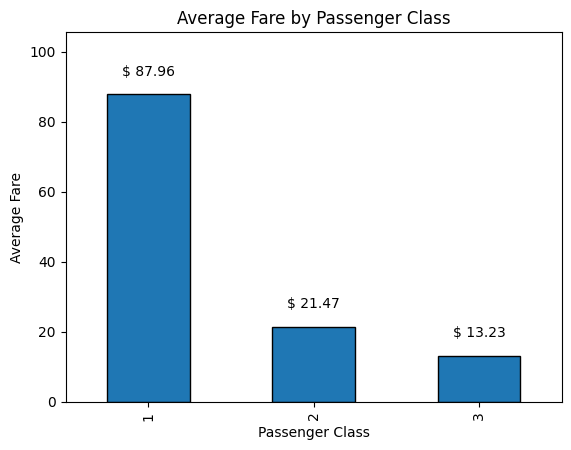

In [23]:
mean_fare_by_pclass = train_df.groupby('Pclass')['Fare'].mean()

ax = mean_fare_by_pclass.plot(kind='bar', edgecolor='black')

plt.xlabel('Passenger Class')
plt.ylabel('Average Fare')
plt.title('Average Fare by Passenger Class')

for i, v in enumerate(mean_fare_by_pclass):
    ax.text(i, v + (0.05 * mean_fare_by_pclass.max()), f"$ {v:.2f}", 
            ha='center', va='bottom')

plt.ylim(0, mean_fare_by_pclass.max() * 1.2)

plt.show()

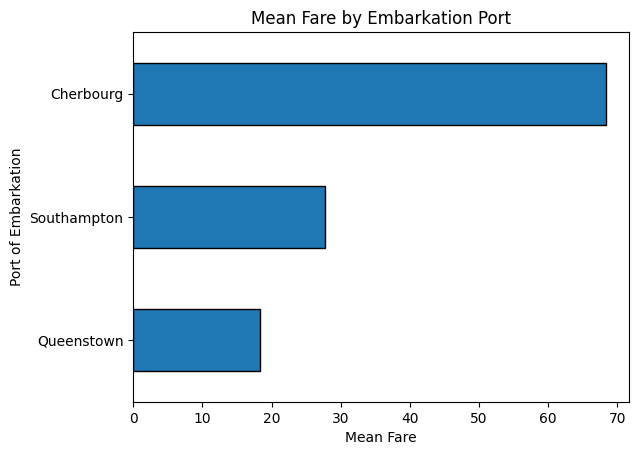

In [24]:
embarked_map = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}

mean_fare_by_embarked = (
    train_df.replace({'Embarked': embarked_map})
            .groupby('Embarked')['Fare']
            .mean()
            .sort_values(ascending=True)
)

mean_fare_by_embarked.plot(kind='barh', edgecolor='black')

plt.ylabel('Port of Embarkation')
plt.xlabel('Mean Fare')
plt.title('Mean Fare by Embarkation Port')
plt.show()

The figure layout has changed to tight


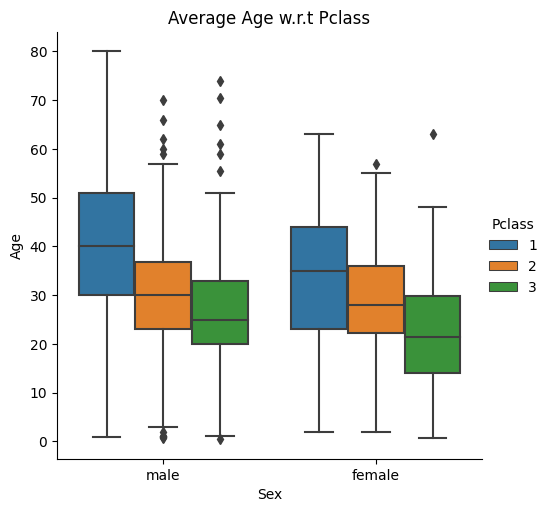

In [25]:
sns.catplot(x="Sex", y="Age", hue="Pclass", data=train_df, kind="box")
plt.title("Average Age w.r.t Pclass")
plt.show()

# Cleaned Dataset

In [26]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,1


In [27]:
df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare', 'SibSp', 'Parch'])

df = pd.get_dummies(df, columns=['Sex'], drop_first=False)

embarked_map = {'Q': 0, 'S': 1, 'C': 2}
df['Embarked'] = df['Embarked'].map(embarked_map)

cabin_order = ['T', 'G', 'F', 'E', 'D', 'C', 'B', 'A']
cabin_map = {letter: idx+1 for idx, letter in enumerate(cabin_order)}
cabin_map['0'] = 0
cabin_map[0] = 0
df['Cabin_Letter'] = df['Cabin_Letter'].map(cabin_map)

df.head()

,Survived,Pclass,Age,Embarked,Cabin_Letter,FamilySize,Sex_female,Sex_male
0,0,3,22.0,1,0,2,False,True
1,1,1,38.0,2,6,2,True,False
2,1,3,26.0,1,0,1,True,False
3,1,1,35.0,1,6,2,True,False
4,0,3,35.0,1,0,1,False,True


invalid value encountered in less


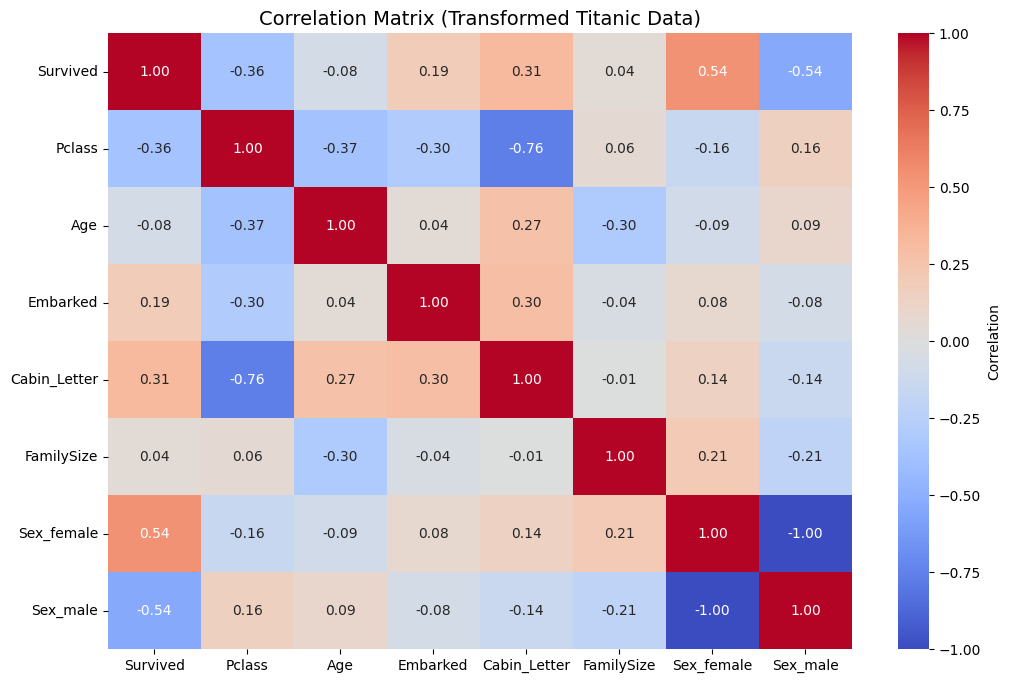

In [28]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix (Transformed Titanic Data)", fontsize=14)
plt.show()

# Model Trainning

In [29]:
import pandas as pd

def preprocess_titanic(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df = pd.get_dummies(df, columns=['Sex'], drop_first=False)

    embarked_map = {'Q': 0, 'S': 1, 'C': 2}
    df['Embarked'] = df['Embarked'].map(embarked_map)

    cabin_order = ['G', 'F', 'E', 'D', 'C', 'B', 'A', 'T']
    cabin_map = {letter: idx+1 for idx, letter in enumerate(cabin_order)}
    cabin_map['0'] = 0
    cabin_map[0] = 0

    df['Cabin_Letter'] = df['Cabin'].fillna('0').astype(str).str[0]
    df['Cabin_Letter'] = df['Cabin_Letter'].map(cabin_map).fillna(0)

    df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin','Fare', 'SibSp', 'Parch'], errors='ignore')

    df = df.dropna()

    return df

In [30]:
cleaned_test_df = preprocess_titanic(merged_test_df)
cleaned_test_df = cleaned_test_df[df.columns]
cleaned_test_df.head()

,Survived,Pclass,Age,Embarked,Cabin_Letter,FamilySize,Sex_female,Sex_male
0,0,3,34.5,0,0,1,False,True
1,1,3,47.0,1,0,2,True,False
2,0,2,62.0,0,0,1,False,True
3,0,3,27.0,1,0,1,False,True
4,1,3,22.0,1,0,3,True,False


In [31]:
# Features and target
X_train = df.drop(columns=['Survived'])
y_train = df['Survived']

X_test = cleaned_test_df.drop(columns=['Survived'])
y_test = cleaned_test_df['Survived']

In [32]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

f1_log = f1_score(y_test, y_pred_log)
print("Logistic Regression F1 Score:", f1_log)

Logistic Regression F1 Score: 0.8846153846153845


In [33]:
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

f1_tree = f1_score(y_test, y_pred_tree)
print("Decision Tree F1 Score:", f1_tree)

Decision Tree F1 Score: 0.8633093525179856


# Model Explanation

## Confusion Matrix

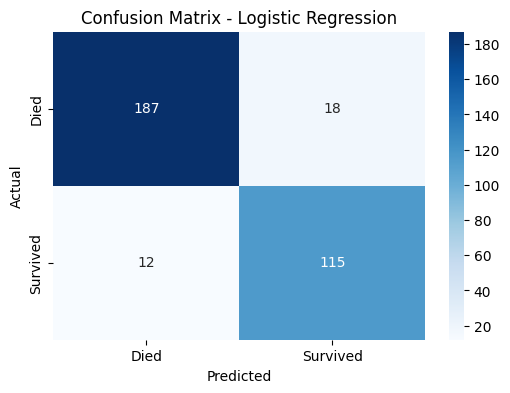

In [34]:
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", xticklabels=["Died","Survived"], yticklabels=["Died","Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


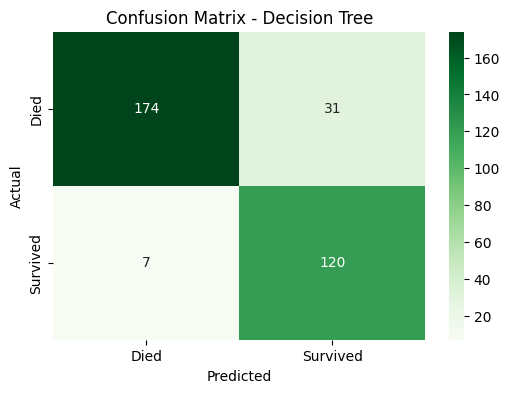

In [35]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6,4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Greens", xticklabels=["Died","Survived"], yticklabels=["Died","Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

## Shap Explanation

In [36]:
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)

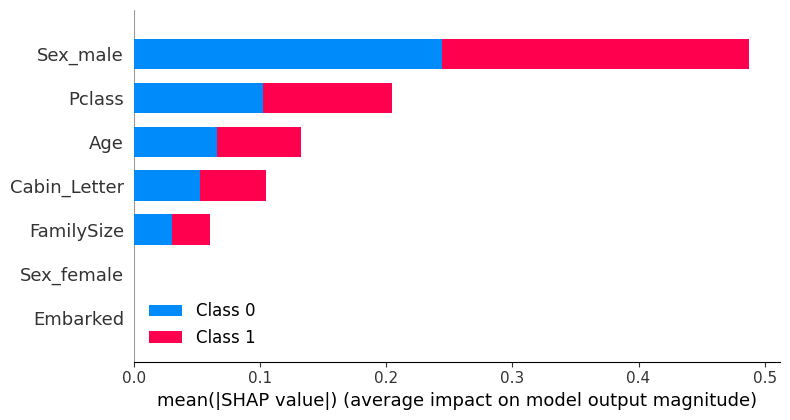

In [37]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [38]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

explainer = shap.LinearExplainer(log_model, X_train)
shap_values = explainer.shap_values(X_test)

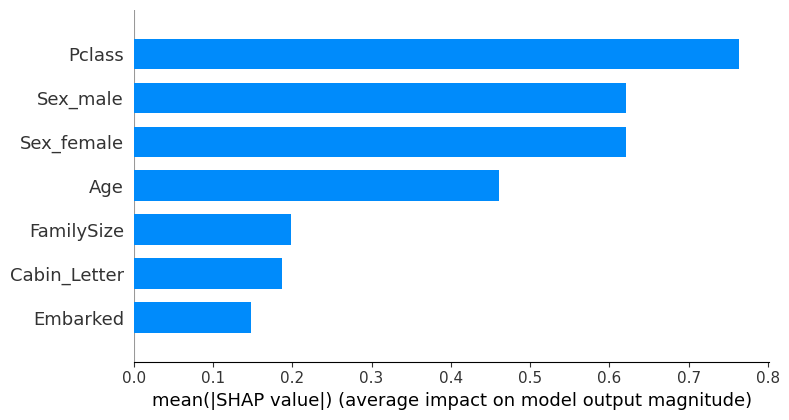

In [39]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## ROC Curve

In [40]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(7,7))

    for name, model in models.items():
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
        except:
            y_prob = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


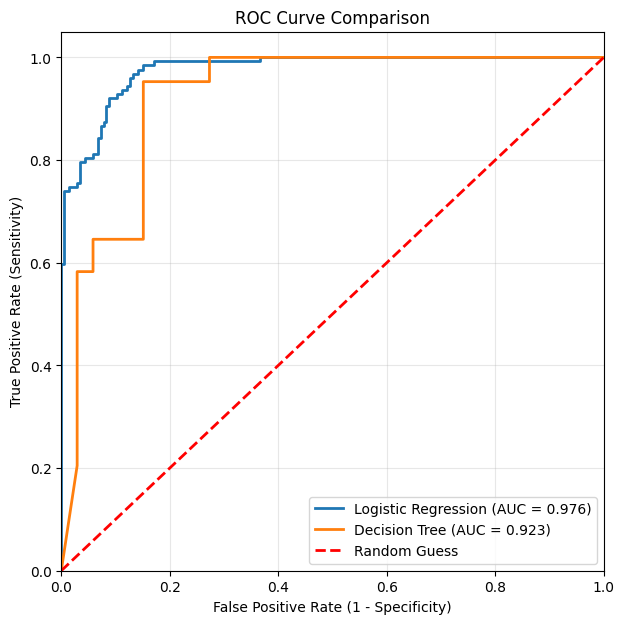

In [41]:
models = {
    "Logistic Regression": log_model,
    "Decision Tree": tree_model
}

plot_roc_curves(models, X_test, y_test)


# Model Explanation

**Feature Alignment**: Titanic features (class, sex, age) align well with Logistic Regression’s linear assumptions.

**Preprocessing Advantage**: Clean, numerical features and one-hot encoding fit naturally with Logistic Regression, while Decision Trees gain less from this.

**Generalization**: With \~700 samples after cleaning, Logistic Regression’s simpler structure generalizes more effectively.

**ROC Curve**: Logistic Regression produces smooth, stable ROC curves, whereas Decision Trees yield jagged ones due to hard, rule-based splits.